In [57]:
import pandas as pd
from pyspark.mllib.recommendation import ALS, Rating
from pyspark.sql import Row

#Provide Path of ratings.csv dataset in "path" variable
path_rating="C:\\Program Files\\Git\\MyGitFilesDirectory\\data\\retail_db\\orders\\ml-latest-small\\ratings.csv"
path_movie="C:\\Program Files\\Git\\MyGitFilesDirectory\\data\\retail_db\\orders\\ml-latest-small\\movies.csv"

#Raw Data in RDD
rat=sc.textFile(path_rating)
mov=sc.textFile(path_movie)

#Transformation....using first 10000 movieid because rest are outliners
header=rat.first()
ratings=rat.filter(lambda x: x!=header).map(lambda rec:rec.split(","))
ratings=ratings.map(lambda rec: (int(rec[0]),int(rec[1]),float(rec[2]))).filter(lambda x: (x[1]<6000))


movies=mov.map(lambda rec:rec.split(","))

ratingsDF=ratings.toDF().na.drop()


In [60]:

#ALS in RDD
ratings = ratings.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
training,test=ratings.randomSplit([0.99,0.01],10)
rank = 50
numIterations = 10
model = ALS.train(training,rank,numIterations,0.01 )
testdataRDD1 = test.map(lambda p: (p[0], p[1]))
predictionsRDD1 = model.predictAll(testdataRDD1).map(lambda r: (r[1], r[2]))
predictionsRDD1 = model.predictAll(testdataRDD1).map(lambda r: (r[1], r[2]))

testdataRDD = training.map(lambda p: (p[0], p[1]))
predictionsRDD = model.predictAll(testdataRDD).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPredsRDD = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictionsRDD)
MSERDD = ratesAndPredsRDD.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error in RDD is = " + str(MSERDD)+"\nPercentage error is " + str(MSERDD*20)+"%")


Mean Squared Error in RDD is = 0.027146741037879746
Percentage error is 0.5429348207575949%


In [62]:
#ALS in DataFrame
trainingDF,testDF=ratingsDF.randomSplit([0.99,0.01],10)
model1 = ALS.train(trainingDF, rank,numIterations,0.01 )
testdataDF1 = test.map(lambda p: (p[0], p[1]))
predictionsDF1 = model1.predictAll(testdataDF1).map(lambda r: (r[1],r[2]))


testdataDF1 = training.map(lambda p: (p[0], p[1]))
predictionsDF = model1.predictAll(testdataDF).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPredsDF = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictionsDF)
MSEDF = ratesAndPredsDF.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of DataFrame is= " + str(MSEDF)+"\nPercentage error is " + str(MSEDF*20)+"%")
print("\n\nClearly PErcentage error in Data Frame is higher")

Mean Squared Error of DataFrame is= 0.0574024635516163
Percentage error is 1.148049271032326%


Clearly PErcentage error in Data Frame is higher


In [63]:
predictionsRDD=predictionsRDD.map(lambda x:(x[0][1],x[1]))
predictionsRDD=predictionsRDD.combineByKey(lambda value: (value, 1),
                             lambda x, value: (x[0] + value, x[1] + 1),
                             lambda x, y: (x[0] + y[0], x[1] + y[1])).map(lambda x:(x[0],(x[1][0]/x[1][1])))


header=movies.first()
movies=movies.filter(lambda rec: rec!=header)
movies=movies.map(lambda l: (int(l[0]),l[1]))

In [64]:
a=predictionsRDD.join(movies).map(lambda rec:(rec[1][1],rec[1][0]))
print("Average Movie rating using ALS in RDD")
a.collect()

Average Movie rating using ALS in RDD


[('Bonnie and Clyde (1967)', 3.8691895712512157),
 ('"Color of Paradise', 4.524962985695186),
 ('Bad Lieutenant (1992)', 3.3269159804401442),
 ('"Secret Agent', 4.097222643522718),
 ('Casablanca (1942)', 4.205140460890449),
 ('I Want to Live! (1958)', 4.111108811916795),
 ('Up Close and Personal (1996)', 3.5007852383629605),
 ('Under Siege 2: Dark Territory (1995)', 3.009598556394053),
 ('Penny Serenade (1941)', 3.212283928175401),
 ('Kate & Leopold (2001)', 2.8321349791855934),
 ('Dying Young (1991)', 2.597578889316781),
 ('Life or Something Like It (2002)', 3.9851219983526995),
 ('Exit Wounds (2001)', 2.2443273998812217),
 ('Wallace & Gromit: The Wrong Trousers (1993)', 4.096012975653325),
 ('Congo (1995)', 2.332344639642402),
 ('Manhattan Murder Mystery (1993)', 3.809736347974094),
 ('Bad Moon (1996)', 3.06554239584888),
 ('Career Girls (1997)', 2.362993078331009),
 ('Left Behind II: Tribulation Force (2002)', 0.7717653596828167),
 ('"Invisible Man', 3.2927400944896275),
 ('Rain (19

In [65]:
b = a.map(lambda p: Row(Movie_Name=p[0],Average_Rating_using_ALS=p[1]))
b=spark.createDataFrame(b)
print("Average Movie rating using ALS in Data Frame is")
b.show(100)

Average Movie rating using ALS in Data Frame is
+------------------------+--------------------+
|Average_Rating_using_ALS|          Movie_Name|
+------------------------+--------------------+
|      3.8691895712512157|Bonnie and Clyde ...|
|       4.524962985695186|  "Color of Paradise|
|      3.3269159804401442|Bad Lieutenant (1...|
|       4.097222643522718|       "Secret Agent|
|       4.205140460890449|   Casablanca (1942)|
|       4.111108811916795|I Want to Live! (...|
|      3.5007852383629605|Up Close and Pers...|
|       3.009598556394053|Under Siege 2: Da...|
|       3.212283928175401|Penny Serenade (1...|
|      2.8321349791855934|Kate & Leopold (2...|
|       2.597578889316781|  Dying Young (1991)|
|      3.9851219983526995|Life or Something...|
|      2.2443273998812217|  Exit Wounds (2001)|
|       4.096012975653325|Wallace & Gromit:...|
|       2.332344639642402|        Congo (1995)|
|       3.809736347974094|Manhattan Murder ...|
|        3.06554239584888|     Bad Moon 

In [66]:
XRDD=predictionsRDD1.map(lambda rec:(rec[0])).collect()
YRDD=predictionsRDD1.map(lambda rec:(rec[1])).collect()
XDF=predictionsDF1.map(lambda rec:(rec[0])).collect()
YDF=predictionsDF1.map(lambda rec:(rec[1])).collect()

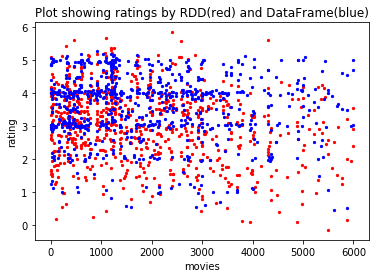

Here it is clearly seen that the predicted rating from RDD is lower than that of DataFrame


In [67]:
import matplotlib.pyplot as plt
plt.scatter(XRDD,YRDD,marker='.',color="red",s=20)
plt.scatter(XDF,YDF,marker='.',color="blue",s=20)
plt.xlabel('movies')
plt.ylabel('rating')
plt.title("Plot showing ratings by RDD(red) and DataFrame(blue)")
plt.legend()
plt.show()
print("Here it is clearly seen that the predicted rating from RDD is lower than that of DataFrame")


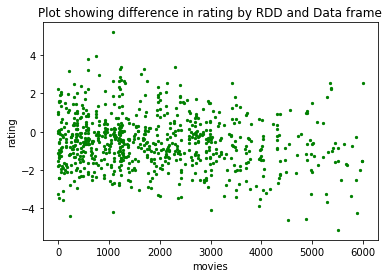

Difference of RDD and DataFrame lying mostly between +2 and -2


In [68]:
diff = [(a - b) for a, b in zip(YRDD, YDF)]
plt.scatter(XRDD,diff,marker='.',color="green",s=20)
plt.xlabel('movies')
plt.ylabel('rating')
plt.title("Plot showing difference in rating by RDD and Data frame")
plt.legend()
plt.show()
print("Difference of RDD and DataFrame lying mostly between +2 and -2" )



In [22]:
ratesAndPredsRDD.collect()

[((15, 1079), (4.0, 2.450845154658283)),
 ((15, 2987), (4.0, 2.859058156871639)),
 ((15, 3435), (2.5, 3.134590851311753)),
 ((15, 5283), (3.0, 1.4302677620062136)),
 ((23, 1219), (5.0, 3.697328950830433)),
 ((23, 3435), (4.5, 3.3331936496075243)),
 ((30, 2124), (4.0, 3.462556808104152)),
 ((30, 2144), (3.0, 3.368960491040312)),
 ((30, 3316), (2.0, 1.431408926340591)),
 ((30, 3468), (5.0, 4.1908373967405055)),
 ((32, 266), (3.0, 5.823402143589665)),
 ((35, 1231), (1.5, 1.405900005986368)),
 ((38, 16), (4.5, 5.200922725983774)),
 ((41, 849), (4.0, 3.016728161312983)),
 ((43, 1883), (3.0, 3.2531542776511984)),
 ((57, 2037), (4.0, 0.7212534608283556)),
 ((66, 1200), (3.0, 4.187547494675043)),
 ((70, 32), (4.0, 3.984860559770512)),
 ((73, 377), (3.0, 4.0753187809452625)),
 ((73, 2605), (2.0, 2.9737831974667137)),
 ((73, 3785), (3.0, 2.956634292688957)),
 ((74, 1876), (3.0, 4.436278864580006)),
 ((77, 3897), (3.0, 2.926558540287254)),
 ((90, 1500), (5.0, 3.45821129765253)),
 ((102, 800), (4.